# Import Modules

In [53]:
import torch
import os, sys, pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('default')

%reload_ext autoreload
%autoreload 2

# Load Data

In [67]:
with open('../data/fungal_cell_positions.pickle', 'rb') as handle:
    fungal_cell_positions = pickle.load(handle)
    
wns = np.load("../data/wns.npz")["wn"]

In [68]:
filename = "../data/fungi.npz"  
wn_fungi = np.load(filename)["wn"]
spectra = np.load(filename)["im"]

spectra = at_wavenumbers(wn_fungi, wns, spectra)
im = spectra.reshape(128, 128, -1)

# Load Model

In [21]:
from models import Sirisp

device = "cuda:0"
model = Sirisp().float().to(device)
model.load_state_dict(torch.load("weights/pretrained_weights.t7"))
        
model.eval();

# Test ISP Solver

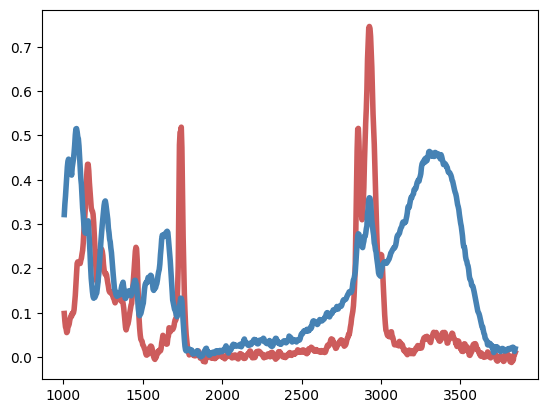

In [72]:
idx = 2
ymin, ymax, xmin, xmax = fungal_cell_positions[idx]
spec = im[ymin:ymax, xmin:xmax, :]

Nx, Ny = spec.shape[0], spec.shape[1]
spec = spec.reshape(Nx*Ny, spec.shape[2])
sign_str = spec.sum(axis=1)
sign_str /= sign_str.max()
qt = sign_str > 0.5
spec = spec[qt].mean(axis=0)
    
outputs, inner_pred, outer_pred = model(torch.from_numpy(spec[np.newaxis, 
                                                              np.newaxis, :]).float().to(device)) 

rs_pred = outputs.cpu().detach().numpy()[0][:2]
n0s_pred = outputs.cpu().detach().numpy()[0][2:]
inner = inner_pred.cpu().detach().numpy().squeeze()
outer = outer_pred.cpu().detach().numpy().squeeze()

# set_publication_context()
plt.plot(wns, inner, "indianred", lw=4, label="Cell Interior")
plt.plot(wns, outer, "steelblue", lw=4, label="Cell Wall")
# set_legend(outer, inner)
plt.show()